In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
################################################################################
# Data Statistics                                                              #
################################################################################


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)
print()
print()
################################################################################
# device

import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')
print()
print()
################################################################################
import os 
from collections import Counter

# global word list that contains every words in the training dataset
# one specific word can show up several times!
global_word_list = [] 


#extracting words from train-positive data 
for filename in os.listdir("./data/train/positive"):
  with open(os.path.join("./data/train/positive", filename), 'r') as f:
    text = f.read()
    words = text.split()
    global_word_list = global_word_list + words
#extracting words from train-negative data 
for filename in os.listdir("./data/train/negative"):
  with open(os.path.join("./data/train/negative", filename), 'r') as f:
    text = f.read()
    words = text.split()
    global_word_list = global_word_list + words

Counter = Counter(global_word_list)
most_frequent_10k_words_list = Counter.most_common(10000)
#print(most_frequent_10k_words_list)
print("10k most frequent words : "+str(len(most_frequent_10k_words_list)))
print()
print()
################################################################################
#check total number of unique words in T

global_word_set = set()
for x in global_word_list:
  global_word_set.add(x)
#print(global_word_set)  
print("total number of unique words in T : "+str(len(global_word_set)))
print()
print()
################################################################################
#check the total number of training examples in T

training_examples_count = 0
for filename in os.listdir("./data/train/positive"):
  training_examples_count = training_examples_count + 1
for filename in os.listdir("./data/train/negative"):
  training_examples_count = training_examples_count + 1

print("total number of training examples in T : "+str(training_examples_count))
print()
print()
################################################################################
#check the average length of document in T
# average length = total number of words / total number of examples

average_length_of_document = len(global_word_list) / training_examples_count
print("the average length of document in T : "+str(average_length_of_document))
print()
print()
################################################################################
#check the max length of document in T

max_length = 0

for filename in os.listdir("./data/train/positive"):
  with open(os.path.join("./data/train/positive", filename), 'r') as f:
    text = f.read()
    words = text.split()
    if len(words) > max_length:
      max_length = len(words)
for filename in os.listdir("./data/train/negative"):
  with open(os.path.join("./data/train/negative", filename), 'r') as f:
    text = f.read()
    words = text.split()
    if len(words) > max_length:
      max_length = len(words)

print("the max length of document in T : "+str(max_length))
max_length = 4096 # 그냥 넉넉하게 4096 으로 하자.
print()
print()
################################################################################
# most_frequent_10k_words_list 에 <unk> , <pad> 추가하고, 이걸로 word_to_ix = {} 만들자.

#print("most_frequent_10k_words_list : ",most_frequent_10k_words_list)  
#print("size of most_frequent_10k_words_list : "+str(len(most_frequent_10k_words_list)))

# word_to_ix 딕셔너리 : word token 에 index 할당
word_to_ix = {}
word_to_ix['<unk>'] = 0
word_to_ix['<pad>'] = 1
for word in most_frequent_10k_words_list:
  if word[0] not in word_to_ix:
    word_to_ix[word[0]] = int(len(word_to_ix)) #assign each word with a unique index
#print()
#print("word_to_ix : ",word_to_ix)
print("size of word_to_ix : ", len(word_to_ix))

import torchtext
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

# prepare_sequence 함수 : sentence 의 각 word 를 index 로 변환 : "I am a boy ."-> [4, 18, 39, 158, 3]
def prepare_sequence(seq, to_ix):
  tokenized_seq = tokenizer(seq)
  idxs = [to_ix[w] if w in to_ix else to_ix['<unk>'] for w in tokenized_seq] #  else '<unk>'
  while (len(idxs) < max_length):  # padding for fitting to max_length size
    #idxs.append(to_ix['<pad>'])   # post-padding : 리스트 맨 뒤에 <pad> 추가 : batch input 들어갈때, model에서 lstm output으로 batch_size개의 모두 동일한 값들이 튀어나옴.
    idxs.insert(0,to_ix['<pad>'])  # pre-padding : 리스트 맨 앞에 <pad> 추가
  return torch.tensor(idxs, dtype=torch.long)

print()
print()
################################################################################
# 출력이 긴것들, 일단 주석처리함.

#print(global_word_set)
#print("most_frequent_10k_words_list : ",most_frequent_10k_words_list)  
#print("size of most_frequent_10k_words_list : "+str(len(most_frequent_10k_words_list)))

#print("word_to_ix : ",word_to_ix)
#print("size of word_to_ix : ", len(word_to_ix))

################################################################################

print()
print()
################################################################################

print()
print()
################################################################################





cuda:0 is available


10k most frequent words : 10000


total number of unique words in T : 24473


total number of training examples in T : 2000


the average length of document in T : 187.677


the max length of document in T : 3816


size of word_to_ix :  10002








In [2]:
################################################################################
# RNN w/o pretrained embedding           DATASET, DATALOADER                   #
################################################################################

#CUSTOM DATASET 만들기

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
from collections import OrderedDict

import os
import pandas as pd
from torchvision.io import read_image

class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # label indexing
        self.ordered_dic = OrderedDict()
        onlyfiles = [f for f in listdir(img_dir+"/positive") if isfile(join(img_dir+"/positive",f))]
        for f in onlyfiles:
          self.ordered_dic[int(f)] = 1
        onlyfiles = [f for f in listdir(img_dir+"/negative") if isfile(join(img_dir+"/negative",f))]
        for f in onlyfiles:
          self.ordered_dic[int(f)] = 0

        self.ordered_dic = OrderedDict(sorted(self.ordered_dic.items(), key=lambda item: item))


        # data indexing
        self.ordered_dic2 = OrderedDict()
        onlyfiles = [f for f in listdir(img_dir+"/positive") if isfile(join(img_dir+"/positive", f))]
        for f in onlyfiles:
          with open(join(img_dir+"/positive", str(f)),'r') as txt:
            text = txt.readlines()
            self.ordered_dic2[int(f)] = prepare_sequence(text[0], word_to_ix)
        onlyfiles = [f for f in listdir(img_dir+"/negative") if isfile(join(img_dir+"/negative", f))]
        for f in onlyfiles:
          with open(join(img_dir+"/negative", str(f)),'r') as txt:
            text = txt.readlines()
            self.ordered_dic2[int(f)] = prepare_sequence(text[0], word_to_ix)

        self.ordered_dic2 = OrderedDict(sorted(self.ordered_dic2.items(), key=lambda item: item))


    def __len__(self):
        return len(self.ordered_dic)

    def __getitem__(self, idx):
        tokenized_sentence = self.ordered_dic2[idx]
        label = self.ordered_dic[idx]
        if self.transform:
            text = self.transform(text)
        if self.target_transform:
            label = self.target_transform(label)
        return tokenized_sentence, label


#DATALOADER
from torch.utils.data import DataLoader

batch_size = 5

train_data = CustomDataset("./data/train/")
test_data = CustomDataset("./data/test_answer/")

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
print("Dataset, DataLoader RNN w/o pretrained embedding is completed!")

Dataset, DataLoader RNN w/o pretrained embedding is completed!


Epoch [1/20], Step [100/400], Loss: 0.6604
Epoch [1/20], Step [200/400], Loss: 0.7000
Epoch [1/20], Step [300/400], Loss: 0.8153
Epoch [1/20], Step [400/400], Loss: 0.5397
epoch : 1, train acc : 55.75 % , train loss : 0.6755649747230287
Epoch [1/20], Step [100/400], Loss: 0.5598
Epoch [1/20], Step [200/400], Loss: 0.6979
Epoch [1/20], Step [300/400], Loss: 0.4557
Epoch [1/20], Step [400/400], Loss: 0.7535
epoch : 1, test acc : 63.75 % , test loss : 0.6243365691650095
Epoch [2/20], Step [100/400], Loss: 0.6055
Epoch [2/20], Step [200/400], Loss: 0.6131
Epoch [2/20], Step [300/400], Loss: 0.4974
Epoch [2/20], Step [400/400], Loss: 0.4691
epoch : 2, train acc : 69.0 % , train loss : 0.5588005783976709
Epoch [2/20], Step [100/400], Loss: 0.9537
Epoch [2/20], Step [200/400], Loss: 0.7235
Epoch [2/20], Step [300/400], Loss: 1.0307
Epoch [2/20], Step [400/400], Loss: 0.5158
epoch : 2, test acc : 62.0 % , test loss : 0.6160571661433688
Epoch [3/20], Step [100/400], Loss: 0.5613
Epoch [3/20], S

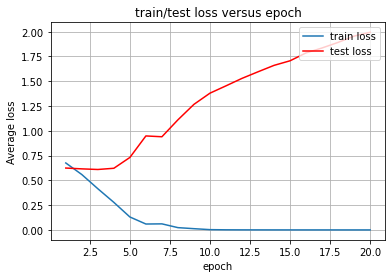

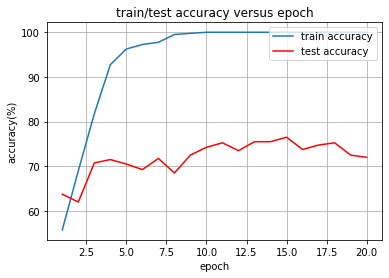

training and testing time(s) :  398.09152388572693


In [ ]:
################################################################################
# RNN w/o pretrained embedding           NETWORK, TRAINING, TESTING, PLOTTING  #
################################################################################

# NETWORK MAKING... #신버전 lr 0.001 실험중... # RNN w/o pretrained embedding
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import time
start_time = time.time()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = max_length
input_size = 100
hidden_size = 100
num_layers = 1
num_classes = 1 # binary classification
#batch_size = 1 # dataloader에서 거기서 batch_size 값 넣어줘야됨.
num_epochs = 20
learning_rate = 0.001
vocab_size = len(word_to_ix) # 추가
embedding_dim = 100 # 추가

# Recurrent neural network (many-to-one)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size # 추가
        self.embedding_dim = embedding_dim # 추가
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim) # 추가
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        
        # Embedding 추가
        x = self.embedding_layer(x) # 추가
        
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # 잠깐 h0, c0가 뭐지? shape은?
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        
        out = torch.sigmoid(out) #BCEWithLogitsLoss를 사용할땐, 여기선 sigmoid 사용안함.
        
        return out

model = LSTM(input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_dataloader)


train_loss  = []##
train_acc = []##
test_loss = []##
test_acc = []##
best_test_acc = -1##

for epoch in range(num_epochs):
    

    
    #test code##############
    #for i, (images, labels) in enumerate(train_dataloader):
    #    print("data:",images)
    #    print("labels:",labels)
    #    print()
    ########################
    
    

    ################# TRAIN ###############################
    tmp_train_loss = 0.0
    tmp_train_acc = 0.0
    train_corrects = 0
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.reshape(-1, sequence_length).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            train_corrects = train_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_train_loss += loss.item()
        
    tmp_train_loss  /= len(train_dataloader)   
    tmp_train_acc = 100.0 * train_corrects/len(train_dataloader)
    train_loss.append(tmp_train_loss)
    train_acc.append(tmp_train_acc)
    
    print('epoch : {}, train acc : {} % , train loss : {}'.format(epoch+1, tmp_train_acc, tmp_train_loss))
    
    ################# TEST ###################################
    tmp_test_loss = 0.0
    tmp_test_acc = 0.0
    test_corrects = 0
    for i, (images, labels) in enumerate(test_dataloader):

        images = images.reshape(-1, sequence_length).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            test_corrects = test_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_test_loss += loss.item()
        
    tmp_test_loss  /= len(test_dataloader)   
    tmp_test_acc = 100.0 * test_corrects/len(test_dataloader)
    test_loss.append(tmp_test_loss)
    test_acc.append(tmp_test_acc)
    
    print('epoch : {}, test acc : {} % , test loss : {}'.format(epoch+1, tmp_test_acc, tmp_test_loss))    
    
    #print("data:",out)###########################
    #print("shape:",out.shape)####################
    #print()#######################################
    
best_test_acc = max(test_acc)
print('best_test_acc : {} %'.format(best_test_acc))
    
x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test loss versus epoch")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.plot(x, train_loss, label="train loss")
plt.plot(x, test_loss, color='red', label="test loss")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test accuracy versus epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy(%)")
plt.plot(x, train_acc,label="train accuracy")
plt.plot(x, test_acc, color='red', label="test accuracy")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
################################################################################

print("training and testing time(s) : ",time.time() - start_time)

Epoch [1/30], Step [100/400], Loss: 0.6897
Epoch [1/30], Step [200/400], Loss: 0.7007
Epoch [1/30], Step [300/400], Loss: 0.8559
Epoch [1/30], Step [400/400], Loss: 0.5791
epoch : 1, train acc : 58.0 % , train loss : 0.6765971526130753
Epoch [1/30], Step [100/400], Loss: 0.5196
Epoch [1/30], Step [200/400], Loss: 0.6606
Epoch [1/30], Step [300/400], Loss: 0.4836
Epoch [1/30], Step [400/400], Loss: 0.9957
epoch : 1, test acc : 63.5 % , test loss : 0.6357142181602234
Epoch [2/30], Step [100/400], Loss: 0.5914
Epoch [2/30], Step [200/400], Loss: 0.4475
Epoch [2/30], Step [300/400], Loss: 0.4139
Epoch [2/30], Step [400/400], Loss: 0.2928
epoch : 2, train acc : 69.5 % , train loss : 0.5514917597602086
Epoch [2/30], Step [100/400], Loss: 0.7782
Epoch [2/30], Step [200/400], Loss: 0.8821
Epoch [2/30], Step [300/400], Loss: 0.9041
Epoch [2/30], Step [400/400], Loss: 0.4836
epoch : 2, test acc : 65.25 % , test loss : 0.6084318702431594
Epoch [3/30], Step [100/400], Loss: 0.3471
Epoch [3/30], St

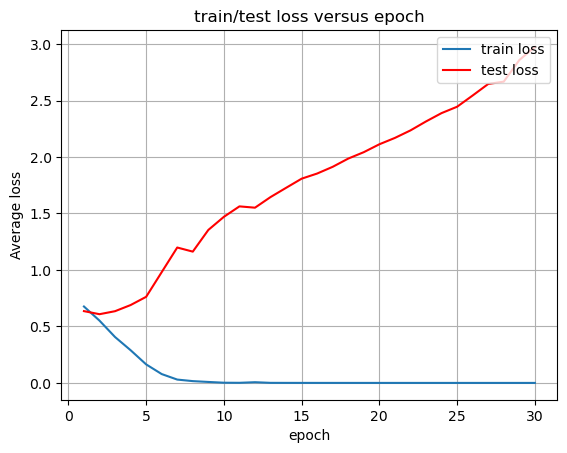

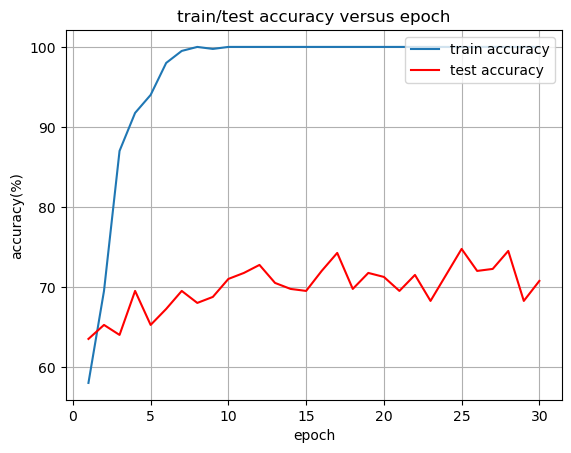

training and testing time(s) :  3197.953988313675


In [3]:
################################################################################
# RNN w/o pretrained embedding           NETWORK, TRAINING, TESTING, PLOTTING  #
################################################################################

# NETWORK MAKING... #신버전 lr 0.001 실험중... # RNN w/o pretrained embedding
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import time
start_time = time.time()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = max_length
input_size = 100
hidden_size = 100
num_layers = 1
num_classes = 1 # binary classification
#batch_size = 1 # dataloader에서 거기서 batch_size 값 넣어줘야됨.
num_epochs = 30
learning_rate = 0.001
vocab_size = len(word_to_ix) # 추가
embedding_dim = 100 # 추가

# Recurrent neural network (many-to-one)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size # 추가
        self.embedding_dim = embedding_dim # 추가
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim) # 추가
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        
        # Embedding 추가
        x = self.embedding_layer(x) # 추가
        
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # 잠깐 h0, c0가 뭐지? shape은?
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        
        out = torch.sigmoid(out) #BCEWithLogitsLoss를 사용할땐, 여기선 sigmoid 사용안함.
        
        return out

model = LSTM(input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_dataloader)


train_loss  = []##
train_acc = []##
test_loss = []##
test_acc = []##
best_test_acc = -1##

for epoch in range(num_epochs):
    

    
    #test code##############
    #for i, (images, labels) in enumerate(train_dataloader):
    #    print("data:",images)
    #    print("labels:",labels)
    #    print()
    ########################
    
    

    ################# TRAIN ###############################
    tmp_train_loss = 0.0
    tmp_train_acc = 0.0
    train_corrects = 0
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.reshape(-1, sequence_length).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            train_corrects = train_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_train_loss += loss.item()
        
    tmp_train_loss  /= len(train_dataloader)   
    tmp_train_acc = 100.0 * train_corrects/len(train_dataloader)
    train_loss.append(tmp_train_loss)
    train_acc.append(tmp_train_acc)
    
    print('epoch : {}, train acc : {} % , train loss : {}'.format(epoch+1, tmp_train_acc, tmp_train_loss))
    
    ################# TEST ###################################
    tmp_test_loss = 0.0
    tmp_test_acc = 0.0
    test_corrects = 0
    for i, (images, labels) in enumerate(test_dataloader):

        images = images.reshape(-1, sequence_length).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            test_corrects = test_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_test_loss += loss.item()
        
    tmp_test_loss  /= len(test_dataloader)   
    tmp_test_acc = 100.0 * test_corrects/len(test_dataloader)
    test_loss.append(tmp_test_loss)
    test_acc.append(tmp_test_acc)
    
    print('epoch : {}, test acc : {} % , test loss : {}'.format(epoch+1, tmp_test_acc, tmp_test_loss))    
    
    #print("data:",out)###########################
    #print("shape:",out.shape)####################
    #print()#######################################
    
best_test_acc = max(test_acc)
print('best_test_acc : {} %'.format(best_test_acc))
    
x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test loss versus epoch")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.plot(x, train_loss, label="train loss")
plt.plot(x, test_loss, color='red', label="test loss")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test accuracy versus epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy(%)")
plt.plot(x, train_acc,label="train accuracy")
plt.plot(x, test_acc, color='red', label="test accuracy")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
################################################################################

print("training and testing time(s) : ",time.time() - start_time)

In [ ]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('./data/all.review.vec.txt')
weights = torch.FloatTensor(model.vectors)

In [ ]:
print(weights)
print(weights.size())

tensor([[ 4.0030e-03,  4.4190e-03, -3.8300e-03,  ...,  1.5240e-03,
          3.0590e-03,  1.9400e-04],
        [ 7.7042e-02, -1.3829e-01,  4.5446e-02,  ..., -4.0849e-02,
         -5.7491e-02, -4.4190e-02],
        [ 7.7455e-02, -1.9632e-01, -3.6069e-02,  ..., -5.4510e-03,
         -2.1463e-02, -6.1124e-02],
        ...,
        [ 2.0505e-01, -1.2456e-01, -3.5018e-01,  ..., -2.1773e-01,
          5.1372e-02, -1.0287e-01],
        [ 5.1180e-01,  4.2875e-01, -3.7108e-01,  ...,  6.1707e-02,
         -6.4810e-02, -1.3690e-01],
        [ 7.1230e-01, -8.3031e-02, -2.4237e-01,  ..., -2.1895e-01,
          6.5033e-02, -3.9334e-01]])
torch.Size([56050, 100])


In [ ]:
print(model['the'])

[ 0.077042 -0.138293  0.045446  0.001055 -0.08971   0.18199   0.101172
  0.066146 -0.20011   0.024411  0.053316 -0.100746  0.067894 -0.353971
  0.04605   0.0333    0.003054 -0.155418  0.110737  0.011296  0.020123
  0.279934  0.038962 -0.151841  0.036768 -0.277104 -0.011198 -0.172451
  0.123047  0.271442 -0.087715  0.026864  0.076209  0.006892 -0.036814
  0.08973   0.098025 -0.148235  0.120976  0.06897   0.147955  0.546389
  0.162051 -0.137083 -0.004736 -0.154369 -0.151037  0.290957  0.042798
 -0.244775  0.159182  0.059657  0.135837  0.164855  0.034198 -0.091813
  0.053724 -0.105167  0.04738   0.065965 -0.04462  -0.11246   0.114897
 -0.086483  0.149818 -0.043314 -0.069482  0.149364  0.192194  0.134079
 -0.192011 -0.000587  0.198898 -0.187188 -0.037097  0.175912  0.041179
  0.26276  -0.325258 -0.219962 -0.014027 -0.039674 -0.10041  -0.28851
 -0.160982 -0.013996 -0.063683  0.001405  0.115892  0.035598  0.089947
  0.161088  0.008904  0.196551 -0.005271  0.18203   0.351794 -0.040849
 -0.057

In [ ]:
import gensim
import numpy as np

model = gensim.models.KeyedVectors.load_word2vec_format('./data/all.review.vec.txt')


print(type(model['</s>']))
print(model['</s>'])
print(type(model['the']))
print(model['the'])

<class 'numpy.ndarray'>
[ 4.003e-03  4.419e-03 -3.830e-03 -3.278e-03  1.367e-03  3.021e-03
  9.410e-04  2.110e-04 -3.604e-03  2.218e-03 -4.356e-03  1.250e-03
 -7.510e-04 -9.570e-04 -3.316e-03 -1.882e-03  2.579e-03  3.025e-03
  2.969e-03  1.597e-03  1.545e-03 -3.803e-03 -4.096e-03  4.970e-03
  3.801e-03  3.090e-03 -6.040e-04  4.016e-03 -4.950e-04  7.350e-04
 -1.490e-04 -2.983e-03  1.312e-03 -1.337e-03 -3.825e-03  4.754e-03
  4.379e-03 -1.095e-03 -2.260e-04  5.090e-04 -3.638e-03 -4.007e-03
  4.555e-03  6.300e-05 -2.582e-03 -3.042e-03 -3.076e-03  1.697e-03
  2.010e-04  1.331e-03 -4.214e-03 -3.808e-03 -1.300e-04  1.144e-03
  2.550e-03 -3.170e-03  4.080e-03  9.270e-04  1.120e-03 -6.080e-04
  2.986e-03 -2.288e-03 -2.097e-03  2.158e-03 -7.530e-04  1.031e-03
  1.805e-03 -4.089e-03 -1.983e-03  2.914e-03  4.232e-03  3.932e-03
 -3.047e-03 -2.108e-03 -9.090e-04  2.001e-03 -3.788e-03  2.998e-03
  2.788e-03 -1.599e-03 -1.552e-03 -2.238e-03  4.229e-03  3.912e-03
 -1.180e-03  4.215e-03  4.820e-03  1.8

In [14]:
################################################################################
# RNN w pretrained embedding             DATASET, DATALOADER                   #
################################################################################

import gensim
import numpy as np

model = gensim.models.KeyedVectors.load_word2vec_format('./data/all.review.vec.txt')
weights = torch.FloatTensor(model.vectors)

zero_list = [0.0 for i in range(100)]

# prepare_sequence 함수 : sentence 의 각 word 를 index 로 변환 : "I am a boy ."-> [4, 18, 39, 158, 3]
def prepare_sequence_for_pretrained(seq):
    tokenized_seq = tokenizer(seq)
    idxs = []
    for x in tokenized_seq:
        #idxs.append(model[x])
        try:
            tmp_list_vec = model[x].tolist() #numpy array -> list, model[x] is numpy array 
            idxs.append(tmp_list_vec)
        except KeyError:
            tmp_list_vec = model['</s>'].tolist()
            idxs.append(tmp_list_vec) # 일종의 unk 토큰
            
    while (len(idxs) < max_length):  # padding for fitting to max_length size
        #idxs.append(model['pad'])   # post-padding : 리스트 맨 뒤에 <pad> 추가 : batch input 들어갈때, model에서 lstm output으로 batch_size개의 모두 동일한 값들이 튀어나옴.
        tmp_list_vec = model['pad'].tolist()
        idxs.insert(0,tmp_list_vec)  # pre-padding : 리스트 맨 앞에 <pad> 추가
    return torch.tensor(idxs, dtype=torch.float32)

#CUSTOM DATASET 만들기 for RNN w pretrained

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
from collections import OrderedDict

import os
import pandas as pd
from torchvision.io import read_image

class CustomDataset_for_pretrained(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # label indexing
        self.ordered_dic = OrderedDict()
        onlyfiles = [f for f in listdir(img_dir+"/positive") if isfile(join(img_dir+"/positive",f))]
        for f in onlyfiles:
          self.ordered_dic[int(f)] = 1
        onlyfiles = [f for f in listdir(img_dir+"/negative") if isfile(join(img_dir+"/negative",f))]
        for f in onlyfiles:
          self.ordered_dic[int(f)] = 0

        self.ordered_dic = OrderedDict(sorted(self.ordered_dic.items(), key=lambda item: item))


        # data indexing
        self.ordered_dic2 = OrderedDict()
        onlyfiles = [f for f in listdir(img_dir+"/positive") if isfile(join(img_dir+"/positive", f))]
        for f in onlyfiles:
          with open(join(img_dir+"/positive", str(f)),'r') as txt:
            text = txt.readlines()
            self.ordered_dic2[int(f)] = prepare_sequence_for_pretrained(text[0])
        onlyfiles = [f for f in listdir(img_dir+"/negative") if isfile(join(img_dir+"/negative", f))]
        for f in onlyfiles:
          with open(join(img_dir+"/negative", str(f)),'r') as txt:
            text = txt.readlines()
            self.ordered_dic2[int(f)] = prepare_sequence_for_pretrained(text[0])

        self.ordered_dic2 = OrderedDict(sorted(self.ordered_dic2.items(), key=lambda item: item))


    def __len__(self):
        return len(self.ordered_dic)

    def __getitem__(self, idx):
        tokenized_sentence = self.ordered_dic2[idx]
        label = self.ordered_dic[idx]
        if self.transform:
            text = self.transform(text)
        if self.target_transform:
            label = self.target_transform(label)
        return tokenized_sentence, label
    
#DATALOADER for RNN w pretrained
from torch.utils.data import DataLoader

batch_size = 5

train_data = CustomDataset_for_pretrained("./data/train/")
test_data = CustomDataset_for_pretrained("./data/hyo_test")

train_dataloader = DataLoader(train_data, batch_size=5, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)
print("Dataset, DataLoader for RNN w pretrained embedding is completed!")

Dataset, DataLoader for RNN w pretrained embedding is completed!


Epoch [1/20], Step [100/400], Loss: 0.6915
Epoch [1/20], Step [200/400], Loss: 0.6663
Epoch [1/20], Step [300/400], Loss: 0.6197
Epoch [1/20], Step [400/400], Loss: 0.9246
epoch : 1, train acc : 54.75 % , train loss : 0.6720387628685108
epoch : 1, test acc : 0.0 % , test loss : 1.3736306965607825
Epoch [2/20], Step [100/400], Loss: 0.6920
Epoch [2/20], Step [200/400], Loss: 0.6419
Epoch [2/20], Step [300/400], Loss: 0.6574
Epoch [2/20], Step [400/400], Loss: 0.7439
epoch : 2, train acc : 61.5 % , train loss : 0.6751267021007682
epoch : 2, test acc : 100.0 % , test loss : 0.32304468412109955
Epoch [3/20], Step [100/400], Loss: 1.5757
Epoch [3/20], Step [200/400], Loss: 0.6811
Epoch [3/20], Step [300/400], Loss: 0.6164
Epoch [3/20], Step [400/400], Loss: 0.6826
epoch : 3, train acc : 56.0 % , train loss : 0.6916768469573411
epoch : 3, test acc : 100.0 % , test loss : 0.5266530227705264
Epoch [4/20], Step [100/400], Loss: 0.8130
Epoch [4/20], Step [200/400], Loss: 0.6158
Epoch [4/20], Ste

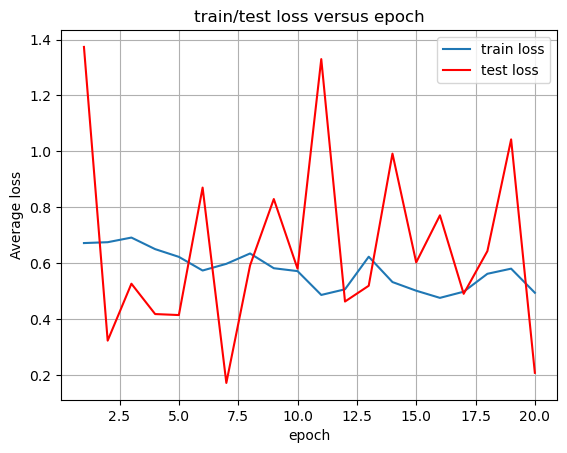

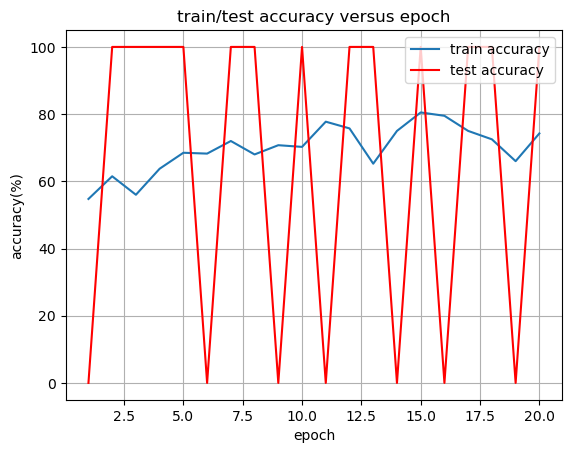

training and testing time(s) :  469.4496600627899


In [16]:
################################################################################
# RNN w pretrained embedding             NETWORK, TRAINING, TESTING, PLOTTING  #
################################################################################

# NETWORK MAKING... #신버전 lr 0.001 실험중... # RNN w pretrained embedding

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import time
start_time = time.time()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = max_length
input_size = 100
hidden_size = 100
num_layers = 1
num_classes = 1 # binary classification
#batch_size = 1 # dataloader에서 거기서 batch_size 값 넣어줘야됨.
num_epochs = 20
learning_rate = 0.001
vocab_size = len(word_to_ix) # 추가
embedding_dim = 100 # 추가

# Recurrent neural network (many-to-one)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size # 추가

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        
        
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # 잠깐 h0, c0가 뭐지? shape은?
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        
        out = torch.sigmoid(out) #BCEWithLogitsLoss를 사용할땐, 여기선 sigmoid 사용안함.
        
        return out

    
model = LSTM(input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_dataloader)


train_loss  = []##
train_acc = []##
test_loss = []##
test_acc = []##
best_test_acc = -1##

for epoch in range(num_epochs):


    
    #test code##############
    #for i, (images, labels) in enumerate(train_dataloader):
    #    print("data:",images)
    #    print("labels:",labels)
    #    print()
    ########################
    
    

    ################# TRAIN ###############################
    tmp_train_loss = 0.0
    tmp_train_acc = 0.0
    train_corrects = 0
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            train_corrects = train_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_train_loss += loss.item()
        
    tmp_train_loss  /= len(train_dataloader)   
    tmp_train_acc = 100.0 * train_corrects/len(train_dataloader)
    train_loss.append(tmp_train_loss)
    train_acc.append(tmp_train_acc)
    
    print('epoch : {}, train acc : {} % , train loss : {}'.format(epoch+1, tmp_train_acc, tmp_train_loss))
    
    ################# TEST ###################################
    tmp_test_loss = 0.0
    tmp_test_acc = 0.0
    test_corrects = 0
    for i, (images, labels) in enumerate(test_dataloader):

        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            test_corrects = test_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_test_loss += loss.item()
        
    tmp_test_loss  /= len(test_dataloader)   
    tmp_test_acc = 100.0 * test_corrects/len(test_dataloader)
    test_loss.append(tmp_test_loss)
    test_acc.append(tmp_test_acc)
    
    print('epoch : {}, test acc : {} % , test loss : {}'.format(epoch+1, tmp_test_acc, tmp_test_loss))    
    
    #print("data:",out)###########################
    #print("shape:",out.shape)####################
    #print()#######################################
    
best_test_acc = max(test_acc)
print('best_test_acc : {} %'.format(best_test_acc))
    
    
x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test loss versus epoch")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.plot(x, train_loss, label="train loss")
plt.plot(x, test_loss, color='red', label="test loss")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test accuracy versus epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy(%)")
plt.plot(x, train_acc,label="train accuracy")
plt.plot(x, test_acc, color='red', label="test accuracy")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
################################################################################

print("training and testing time(s) : ",time.time() - start_time)




In [17]:
print("---------------------------------------------------------------")
for i, (images, labels) in enumerate(test_dataloader):

    images = images.reshape(-1, sequence_length, input_size).to(device)
    labels = labels.to(device)
    #print("data:",images)
    #print("labels:",labels)
    #print()

    #print("labels before as_tensor:",labels)
    #print("labels type before as_tensor:",type(labels))
    labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
    #print("labels after as_tensor:",labels)
    #print("labels type after as_tensor:",type(labels))

    # Forward pass
    outputs = model(images)

    #print("outputs before as_tensor:",outputs)##
    #print("outputs type before as_tensor:",type(outputs))##
    outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
    #print("outputs after as_tensor:",outputs)##
    #print("outputs type after as_tensor:",type(outputs))

    if outputs[-1,0] > 0.5:
        predict = 1
    else:
        predict = 0
    print("the answer is : ",predict)

---------------------------------------------------------------
the answer is :  1


In [9]:
################################################################################
# RNN w pretrained embedding             DATASET, DATALOADER                   #
################################################################################

import gensim
import numpy as np

model = gensim.models.KeyedVectors.load_word2vec_format('./data/all.review.vec.txt')
weights = torch.FloatTensor(model.vectors)

zero_list = [0.0 for i in range(100)]

# prepare_sequence 함수 : sentence 의 각 word 를 index 로 변환 : "I am a boy ."-> [4, 18, 39, 158, 3]
def prepare_sequence_for_pretrained(seq):
    tokenized_seq = tokenizer(seq)
    idxs = []
    for x in tokenized_seq:
        #idxs.append(model[x])
        try:
            tmp_list_vec = model[x].tolist() #numpy array -> list, model[x] is numpy array 
            idxs.append(tmp_list_vec)
        except KeyError:
            tmp_list_vec = model['</s>'].tolist()
            idxs.append(tmp_list_vec) # 일종의 unk 토큰
            
    while (len(idxs) < max_length):  # padding for fitting to max_length size
        #idxs.append(model['pad'])   # post-padding : 리스트 맨 뒤에 <pad> 추가 : batch input 들어갈때, model에서 lstm output으로 batch_size개의 모두 동일한 값들이 튀어나옴.
        tmp_list_vec = model['pad'].tolist()
        idxs.insert(0,tmp_list_vec)  # pre-padding : 리스트 맨 앞에 <pad> 추가
    return torch.tensor(idxs, dtype=torch.float32)

#CUSTOM DATASET 만들기 for RNN w pretrained

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
from collections import OrderedDict

import os
import pandas as pd
from torchvision.io import read_image

class CustomDataset_for_pretrained(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # label indexing
        self.ordered_dic = OrderedDict()
        onlyfiles = [f for f in listdir(img_dir+"/positive") if isfile(join(img_dir+"/positive",f))]
        for f in onlyfiles:
          self.ordered_dic[int(f)] = 1
        onlyfiles = [f for f in listdir(img_dir+"/negative") if isfile(join(img_dir+"/negative",f))]
        for f in onlyfiles:
          self.ordered_dic[int(f)] = 0

        self.ordered_dic = OrderedDict(sorted(self.ordered_dic.items(), key=lambda item: item))


        # data indexing
        self.ordered_dic2 = OrderedDict()
        onlyfiles = [f for f in listdir(img_dir+"/positive") if isfile(join(img_dir+"/positive", f))]
        for f in onlyfiles:
          with open(join(img_dir+"/positive", str(f)),'r') as txt:
            text = txt.readlines()
            self.ordered_dic2[int(f)] = prepare_sequence_for_pretrained(text[0])
        onlyfiles = [f for f in listdir(img_dir+"/negative") if isfile(join(img_dir+"/negative", f))]
        for f in onlyfiles:
          with open(join(img_dir+"/negative", str(f)),'r') as txt:
            text = txt.readlines()
            self.ordered_dic2[int(f)] = prepare_sequence_for_pretrained(text[0])

        self.ordered_dic2 = OrderedDict(sorted(self.ordered_dic2.items(), key=lambda item: item))


    def __len__(self):
        return len(self.ordered_dic)

    def __getitem__(self, idx):
        tokenized_sentence = self.ordered_dic2[idx]
        label = self.ordered_dic[idx]
        if self.transform:
            text = self.transform(text)
        if self.target_transform:
            label = self.target_transform(label)
        return tokenized_sentence, label
    
#DATALOADER for RNN w pretrained
from torch.utils.data import DataLoader

batch_size = 5

train_data = CustomDataset_for_pretrained("./data/train/")
test_data = CustomDataset_for_pretrained("./data/hyo_test")

train_dataloader = DataLoader(train_data, batch_size=5, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)
print("Dataset, DataLoader for RNN w pretrained embedding is completed!")

Dataset, DataLoader for RNN w pretrained embedding is completed!


In [10]:
print("---------------------------------------------------------------")
for i, (images, labels) in enumerate(test_dataloader):

    images = images.reshape(-1, sequence_length, input_size).to(device)
    labels = labels.to(device)
    #print("data:",images)
    #print("labels:",labels)
    #print()

    #print("labels before as_tensor:",labels)
    #print("labels type before as_tensor:",type(labels))
    labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
    #print("labels after as_tensor:",labels)
    #print("labels type after as_tensor:",type(labels))

    # Forward pass
    outputs = model(images)

    #print("outputs before as_tensor:",outputs)##
    #print("outputs type before as_tensor:",type(outputs))##
    outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
    #print("outputs after as_tensor:",outputs)##
    #print("outputs type after as_tensor:",type(outputs))

    if outputs[-1,0] > 0.5:
        predict = 1
    else:
        predict = 0
    print("the answer is : ",predict)

---------------------------------------------------------------


TypeError: 'KeyedVectors' object is not callable

Epoch [1/30], Step [100/400], Loss: 0.6492
Epoch [1/30], Step [200/400], Loss: 0.6794
Epoch [1/30], Step [300/400], Loss: 0.8394
Epoch [1/30], Step [400/400], Loss: 0.4840
epoch : 1, train acc : 63.0 % , train loss : 0.6508281759268969
Epoch [1/30], Step [100/400], Loss: 0.4441
Epoch [1/30], Step [200/400], Loss: 0.3767
Epoch [1/30], Step [300/400], Loss: 0.3666
Epoch [1/30], Step [400/400], Loss: 0.1695
epoch : 1, test acc : 71.0 % , test loss : 0.5966416051618677
Epoch [2/30], Step [100/400], Loss: 0.6003
Epoch [2/30], Step [200/400], Loss: 0.4152
Epoch [2/30], Step [300/400], Loss: 0.6992
Epoch [2/30], Step [400/400], Loss: 0.6578
epoch : 2, train acc : 68.75 % , train loss : 0.6196611858396673
Epoch [2/30], Step [100/400], Loss: 0.6846
Epoch [2/30], Step [200/400], Loss: 0.6623
Epoch [2/30], Step [300/400], Loss: 0.6708
Epoch [2/30], Step [400/400], Loss: 0.6350
epoch : 2, test acc : 57.75 % , test loss : 0.6788563099204903
Epoch [3/30], Step [100/400], Loss: 0.6274
Epoch [3/30], S

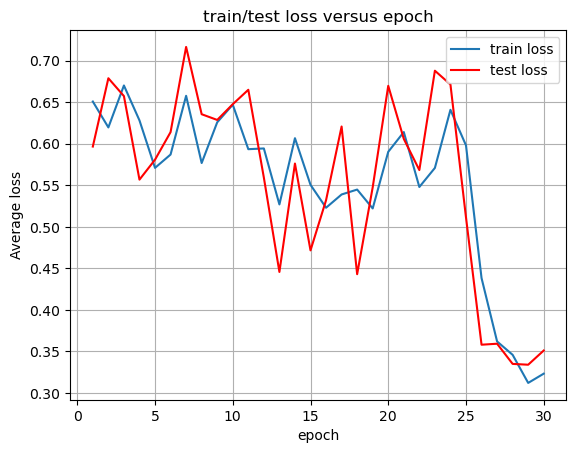

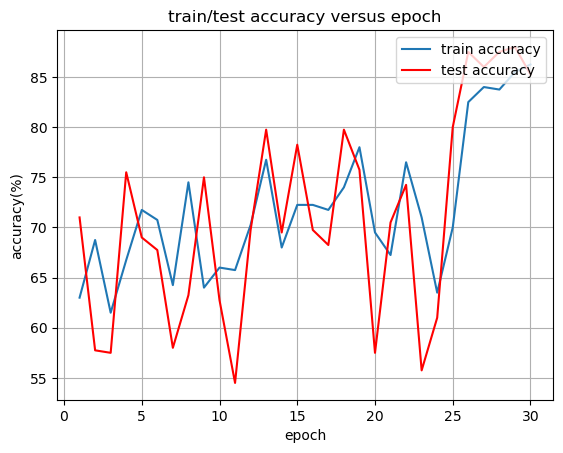

training and testing time(s) :  4359.649777173996


In [5]:
################################################################################
# RNN w pretrained embedding             NETWORK, TRAINING, TESTING, PLOTTING  #
################################################################################

# NETWORK MAKING... #신버전 lr 0.001 실험중... # RNN w pretrained embedding

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import time
start_time = time.time()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = max_length
input_size = 100
hidden_size = 100
num_layers = 1
num_classes = 1 # binary classification
#batch_size = 1 # dataloader에서 거기서 batch_size 값 넣어줘야됨.
num_epochs = 30
learning_rate = 0.001
vocab_size = len(word_to_ix) # 추가
embedding_dim = 100 # 추가

# Recurrent neural network (many-to-one)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size # 추가

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        
        
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # 잠깐 h0, c0가 뭐지? shape은?
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        
        out = torch.sigmoid(out) #BCEWithLogitsLoss를 사용할땐, 여기선 sigmoid 사용안함.
        
        return out

    
model = LSTM(input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_dataloader)


train_loss  = []##
train_acc = []##
test_loss = []##
test_acc = []##
best_test_acc = -1##

for epoch in range(num_epochs):


    
    #test code##############
    #for i, (images, labels) in enumerate(train_dataloader):
    #    print("data:",images)
    #    print("labels:",labels)
    #    print()
    ########################
    
    

    ################# TRAIN ###############################
    tmp_train_loss = 0.0
    tmp_train_acc = 0.0
    train_corrects = 0
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            train_corrects = train_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_train_loss += loss.item()
        
    tmp_train_loss  /= len(train_dataloader)   
    tmp_train_acc = 100.0 * train_corrects/len(train_dataloader)
    train_loss.append(tmp_train_loss)
    train_acc.append(tmp_train_acc)
    
    print('epoch : {}, train acc : {} % , train loss : {}'.format(epoch+1, tmp_train_acc, tmp_train_loss))
    
    ################# TEST ###################################
    tmp_test_loss = 0.0
    tmp_test_acc = 0.0
    test_corrects = 0
    for i, (images, labels) in enumerate(test_dataloader):

        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            test_corrects = test_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_test_loss += loss.item()
        
    tmp_test_loss  /= len(test_dataloader)   
    tmp_test_acc = 100.0 * test_corrects/len(test_dataloader)
    test_loss.append(tmp_test_loss)
    test_acc.append(tmp_test_acc)
    
    print('epoch : {}, test acc : {} % , test loss : {}'.format(epoch+1, tmp_test_acc, tmp_test_loss))    
    
    #print("data:",out)###########################
    #print("shape:",out.shape)####################
    #print()#######################################
    
best_test_acc = max(test_acc)
print('best_test_acc : {} %'.format(best_test_acc))
    
    
x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test loss versus epoch")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.plot(x, train_loss, label="train loss")
plt.plot(x, test_loss, color='red', label="test loss")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test accuracy versus epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy(%)")
plt.plot(x, train_acc,label="train accuracy")
plt.plot(x, test_acc, color='red', label="test accuracy")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
################################################################################

print("training and testing time(s) : ",time.time() - start_time)

In [ ]:
################################################################################
# RNN w pretrained embedding             NETWORK, TRAINING, TESTING, PLOTTING  #
################################################################################

# NETWORK MAKING... #신버전 lr 0.001 실험중... # RNN w pretrained embedding

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import time
start_time = time.time()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = max_length
input_size = 100
hidden_size = 100
num_layers = 1
num_classes = 1 # binary classification
#batch_size = 1 # dataloader에서 거기서 batch_size 값 넣어줘야됨.
num_epochs = 40
learning_rate = 0.001
vocab_size = len(word_to_ix) # 추가
embedding_dim = 100 # 추가

# Recurrent neural network (many-to-one)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size # 추가

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        
        
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # 잠깐 h0, c0가 뭐지? shape은?
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        
        out = torch.sigmoid(out) #BCEWithLogitsLoss를 사용할땐, 여기선 sigmoid 사용안함.
        
        return out

    
model = LSTM(input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_dataloader)


train_loss  = []##
train_acc = []##
test_loss = []##
test_acc = []##
best_test_acc = -1##

for epoch in range(num_epochs):


    
    #test code##############
    #for i, (images, labels) in enumerate(train_dataloader):
    #    print("data:",images)
    #    print("labels:",labels)
    #    print()
    ########################
    
    

    ################# TRAIN ###############################
    tmp_train_loss = 0.0
    tmp_train_acc = 0.0
    train_corrects = 0
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            train_corrects = train_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_train_loss += loss.item()
        
    tmp_train_loss  /= len(train_dataloader)   
    tmp_train_acc = 100.0 * train_corrects/len(train_dataloader)
    train_loss.append(tmp_train_loss)
    train_acc.append(tmp_train_acc)
    
    print('epoch : {}, train acc : {} % , train loss : {}'.format(epoch+1, tmp_train_acc, tmp_train_loss))
    
    ################# TEST ###################################
    tmp_test_loss = 0.0
    tmp_test_acc = 0.0
    test_corrects = 0
    for i, (images, labels) in enumerate(test_dataloader):

        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            test_corrects = test_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_test_loss += loss.item()
        
    tmp_test_loss  /= len(test_dataloader)   
    tmp_test_acc = 100.0 * test_corrects/len(test_dataloader)
    test_loss.append(tmp_test_loss)
    test_acc.append(tmp_test_acc)
    
    print('epoch : {}, test acc : {} % , test loss : {}'.format(epoch+1, tmp_test_acc, tmp_test_loss))    
    
    #print("data:",out)###########################
    #print("shape:",out.shape)####################
    #print()#######################################
    
best_test_acc = max(test_acc)
print('best_test_acc : {} %'.format(best_test_acc))
    
    
x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test loss versus epoch")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.plot(x, train_loss, label="train loss")
plt.plot(x, test_loss, color='red', label="test loss")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test accuracy versus epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy(%)")
plt.plot(x, train_acc,label="train accuracy")
plt.plot(x, test_acc, color='red', label="test accuracy")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
################################################################################

print("training and testing time(s) : ",time.time() - start_time)

Epoch [1/40], Step [100/400], Loss: 0.7936
Epoch [1/40], Step [200/400], Loss: 0.7028
Epoch [1/40], Step [300/400], Loss: 0.5996
Epoch [1/40], Step [400/400], Loss: 0.6408
epoch : 1, train acc : 62.5 % , train loss : 0.6555054137349776
Epoch [1/40], Step [100/400], Loss: 0.6141
Epoch [1/40], Step [200/400], Loss: 0.7078
Epoch [1/40], Step [300/400], Loss: 0.7319
Epoch [1/40], Step [400/400], Loss: 0.4981
epoch : 1, test acc : 61.0 % , test loss : 0.6502531897907455
Epoch [2/40], Step [100/400], Loss: 0.6064
Epoch [2/40], Step [200/400], Loss: 1.0282
Epoch [2/40], Step [300/400], Loss: 0.1942
Epoch [2/40], Step [400/400], Loss: 0.2785
epoch : 2, train acc : 72.0 % , train loss : 0.5767073413895465
Epoch [2/40], Step [100/400], Loss: 0.4012
Epoch [2/40], Step [200/400], Loss: 0.3536
Epoch [2/40], Step [300/400], Loss: 0.4127
Epoch [2/40], Step [400/400], Loss: 0.5363
epoch : 2, test acc : 73.5 % , test loss : 0.5234454137424417
Epoch [3/40], Step [100/400], Loss: 0.5805
Epoch [3/40], Ste

In [ ]:
# -------------------------------------------------------------------------------
# -------------------------------------------------------------------------------
# -------------------------------------------------------------------------------
# -------------------------------------------------------------------------------
# NOW IT'S C----N---N-----TI--------------------------------------------------ME!
# HOLY SHI---------------------------------------------------------------------T!
# -------------------------------------------------------------------------------
# -------------------------------------------------------------------------------
# -------------------------------------------------------------------------------
# -------------------------------------------------------------------------------

In [2]:
################################################################################
# CNN w/o pretrained embedding           DATASET, DATALOADER                   #
################################################################################


#CUSTOM DATASET 만들기

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
from collections import OrderedDict

import os
import pandas as pd
from torchvision.io import read_image

class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # label indexing
        self.ordered_dic = OrderedDict()
        onlyfiles = [f for f in listdir(img_dir+"/positive") if isfile(join(img_dir+"/positive",f))]
        for f in onlyfiles:
          self.ordered_dic[int(f)] = 1
        onlyfiles = [f for f in listdir(img_dir+"/negative") if isfile(join(img_dir+"/negative",f))]
        for f in onlyfiles:
          self.ordered_dic[int(f)] = 0

        self.ordered_dic = OrderedDict(sorted(self.ordered_dic.items(), key=lambda item: item))


        # data indexing
        self.ordered_dic2 = OrderedDict()
        onlyfiles = [f for f in listdir(img_dir+"/positive") if isfile(join(img_dir+"/positive", f))]
        for f in onlyfiles:
          with open(join(img_dir+"/positive", str(f)),'r') as txt:
            text = txt.readlines()
            self.ordered_dic2[int(f)] = prepare_sequence(text[0], word_to_ix)
        onlyfiles = [f for f in listdir(img_dir+"/negative") if isfile(join(img_dir+"/negative", f))]
        for f in onlyfiles:
          with open(join(img_dir+"/negative", str(f)),'r') as txt:
            text = txt.readlines()
            self.ordered_dic2[int(f)] = prepare_sequence(text[0], word_to_ix)

        self.ordered_dic2 = OrderedDict(sorted(self.ordered_dic2.items(), key=lambda item: item))


    def __len__(self):
        return len(self.ordered_dic)

    def __getitem__(self, idx):
        tokenized_sentence = self.ordered_dic2[idx]
        label = self.ordered_dic[idx]
        if self.transform:
            text = self.transform(text)
        if self.target_transform:
            label = self.target_transform(label)
        return tokenized_sentence, label


#DATALOADER
from torch.utils.data import DataLoader

batch_size = 5

train_data = CustomDataset("./data/train/")
test_data = CustomDataset("./data/test_answer/")

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
print("Dataset, DataLoader CNN w/o pretrained embedding is completed!")

Dataset, DataLoader CNN w/o pretrained embedding is completed!


Epoch [1/20], Step [100/400], Loss: 0.6823
Epoch [1/20], Step [200/400], Loss: 0.6948
Epoch [1/20], Step [300/400], Loss: 0.6946
Epoch [1/20], Step [400/400], Loss: 0.6882
epoch : 1, train acc : 50.5 % , train loss : 0.6944346106167374
Epoch [1/20], Step [100/400], Loss: 0.6982
Epoch [1/20], Step [200/400], Loss: 0.6982
Epoch [1/20], Step [300/400], Loss: 0.6887
Epoch [1/20], Step [400/400], Loss: 0.6887
epoch : 1, test acc : 51.75 % , test loss : 0.6934219423254017
Epoch [2/20], Step [100/400], Loss: 0.7021
Epoch [2/20], Step [200/400], Loss: 0.6930
Epoch [2/20], Step [300/400], Loss: 0.6938
Epoch [2/20], Step [400/400], Loss: 0.6925
epoch : 2, train acc : 49.5 % , train loss : 0.6934394564612247
Epoch [2/20], Step [100/400], Loss: 0.6925
Epoch [2/20], Step [200/400], Loss: 0.6950
Epoch [2/20], Step [300/400], Loss: 0.6913
Epoch [2/20], Step [400/400], Loss: 0.6925
epoch : 2, test acc : 50.5 % , test loss : 0.6931520778839547
Epoch [3/20], Step [100/400], Loss: 0.6904
Epoch [3/20], St

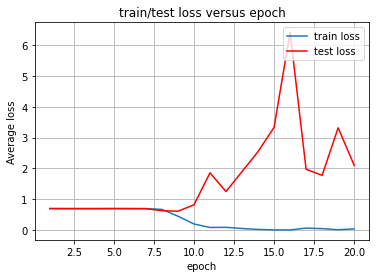

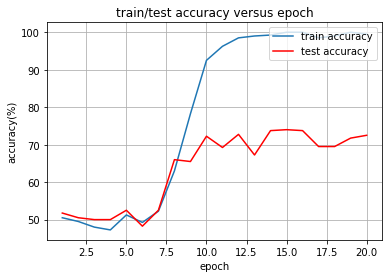

training and testing time(s) :  66.44535040855408


In [ ]:
################################################################################
# CNN w/o pretrained embedding           NETWORK, TRAINING, TESTING, PLOTTING  #
################################################################################

# NETWORK MAKING... #신버전 lr 0.001 실험중... # RNN w/o pretrained embedding
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import time
start_time = time.time()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = max_length
input_size = 100
num_of_kernels = 100
kernel_size = 3
stride = 2
num_layers = 1
num_classes = 1 # binary classification
#batch_size = 1 # dataloader에서 거기서 batch_size 값 넣어줘야됨.
num_epochs = 20
learning_rate = 0.001
vocab_size = len(word_to_ix) # 추가
embedding_dim = 100 # 추가

# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self, input_size, num_of_kernels, kernel_size, num_classes, vocab_size, embedding_dim, stride, sequence_length):
        super(ConvNet, self).__init__()
        #self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_of_kernels = num_of_kernels
        self.kernel_size = kernel_size

        self.num_classes = num_classes
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.stride = stride
        self.sequence_length = sequence_length
        
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d_1 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_2 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_3 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_4 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_5 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_6 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_7 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(1600, num_classes)
        
# !@#$ #
    def forward(self, x):
        
        # Embedding 추가
        x = self.embedding_layer(x) # 추가
        
        # Set initial hidden and cell states 
        #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # 잠깐 h0, c0가 뭐지? shape은?
        
        # Forward propagate Conv1d

        # conv1d 는 lstm 과 달리 input을 (N,C_in,L) 로 인식함. (N:batch size, C_in:input vec dim,  L:seq length)
        # conv1d 에 input으로 x를 넣기 위해
        # x shape : (5,4096,100) -> (5,100,4096)으로 바꿔줘야함.
        x = torch.permute(x, (0,2,1))
        # x shape :torch.Size([5, 100, 4096]) 

        


        # seq 의 앞부분은 많은 수의 padding 때문에 feature가 제대로 저장되지 않았으므로, seq의 중간부터 뒷부분만 가져와서 conv에 태웠다.
        x = self.conv1d_1(x[:,:,2047:-1])  # x[:,:,2047:-1] shape : torch.Size([5, 100, 2048])
        # x shape : torch.Size([5, 100, 1024])
        x = self.relu(x)
        
        x = self.conv1d_2(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 512])
        x = self.relu(x)
        
        x = self.conv1d_3(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 256])
        x = self.relu(x)
       
        x = self.conv1d_4(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 128])
        x = self.relu(x)
    
        x = self.conv1d_5(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 64])
        x = self.relu(x)
        
        x = self.conv1d_6(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 32])
        x = self.relu(x)
        
        x = self.conv1d_7(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 16])
        x = self.relu(x)

        x = torch.flatten(x, start_dim=1, end_dim=-1)
        # x shape : torch.Size([5, 1600])
       
        # Decode the hidden state of the last time step
        x = self.fc(x)
        out = torch.sigmoid(x) #BCEWithLogitsLoss를 사용할땐, 여기선 sigmoid 사용안함.
        
        return out
    

model = ConvNet(input_size, num_of_kernels, kernel_size, num_classes, vocab_size, embedding_dim, stride, sequence_length).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_dataloader)


train_loss  = []##
train_acc = []##
test_loss = []##
test_acc = []##
best_test_acc = -1##

for epoch in range(num_epochs):
    

    
    #test code##############
    #for i, (images, labels) in enumerate(train_dataloader):
    #    print("data:",images)
    #    print("labels:",labels)
    #    print()
    ########################
    
    

    ################# TRAIN ###############################
    tmp_train_loss = 0.0
    tmp_train_acc = 0.0
    train_corrects = 0
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.reshape(-1, sequence_length).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            train_corrects = train_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_train_loss += loss.item()
        
    tmp_train_loss  /= len(train_dataloader)   
    tmp_train_acc = 100.0 * train_corrects/len(train_dataloader)
    train_loss.append(tmp_train_loss)
    train_acc.append(tmp_train_acc)
    
    print('epoch : {}, train acc : {} % , train loss : {}'.format(epoch+1, tmp_train_acc, tmp_train_loss))
    
    ################# TEST ###################################
    tmp_test_loss = 0.0
    tmp_test_acc = 0.0
    test_corrects = 0
    for i, (images, labels) in enumerate(test_dataloader):

        images = images.reshape(-1, sequence_length).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            test_corrects = test_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_test_loss += loss.item()
        
    tmp_test_loss  /= len(test_dataloader)   
    tmp_test_acc = 100.0 * test_corrects/len(test_dataloader)
    test_loss.append(tmp_test_loss)
    test_acc.append(tmp_test_acc)
    
    print('epoch : {}, test acc : {} % , test loss : {}'.format(epoch+1, tmp_test_acc, tmp_test_loss))    
    
    #print("data:",out)###########################
    #print("shape:",out.shape)####################
    #print()#######################################
    
best_test_acc = max(test_acc)
print('best_test_acc : {} %'.format(best_test_acc))
    
    
x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test loss versus epoch")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.plot(x, train_loss, label="train loss")
plt.plot(x, test_loss, color='red', label="test loss")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test accuracy versus epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy(%)")
plt.plot(x, train_acc,label="train accuracy")
plt.plot(x, test_acc, color='red', label="test accuracy")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
################################################################################

print("training and testing time(s) : ",time.time() - start_time)

Epoch [1/30], Step [100/400], Loss: 0.6840
Epoch [1/30], Step [200/400], Loss: 0.7046
Epoch [1/30], Step [300/400], Loss: 0.6923
Epoch [1/30], Step [400/400], Loss: 0.6856
epoch : 1, train acc : 48.5 % , train loss : 0.6943529160994305
Epoch [1/30], Step [100/400], Loss: 0.7020
Epoch [1/30], Step [200/400], Loss: 0.7020
Epoch [1/30], Step [300/400], Loss: 0.6859
Epoch [1/30], Step [400/400], Loss: 0.6859
epoch : 1, test acc : 51.75 % , test loss : 0.6939594684678319
Epoch [2/30], Step [100/400], Loss: 0.7044
Epoch [2/30], Step [200/400], Loss: 0.6949
Epoch [2/30], Step [300/400], Loss: 0.6979
Epoch [2/30], Step [400/400], Loss: 0.6925
epoch : 2, train acc : 47.5 % , train loss : 0.6936198191348352
Epoch [2/30], Step [100/400], Loss: 0.6925
Epoch [2/30], Step [200/400], Loss: 0.6949
Epoch [2/30], Step [300/400], Loss: 0.6914
Epoch [2/30], Step [400/400], Loss: 0.6926
epoch : 2, test acc : 50.5 % , test loss : 0.6931482927981224
Epoch [3/30], Step [100/400], Loss: 0.6913
Epoch [3/30], St

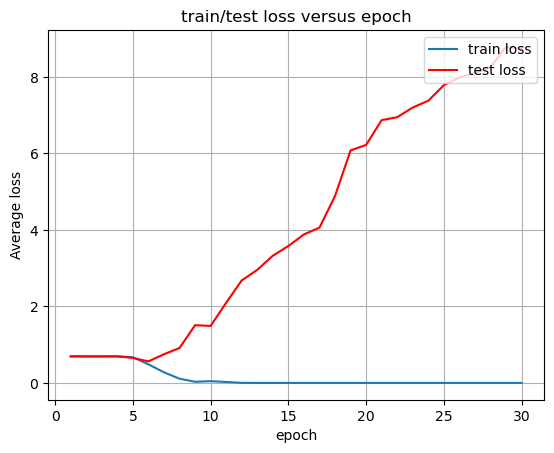

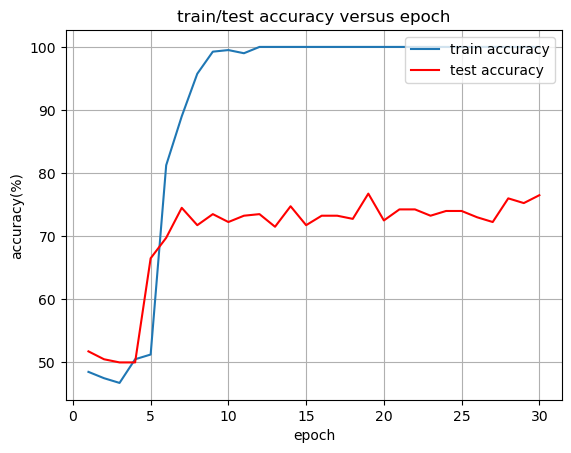

training and testing time(s) :  246.08992671966553


In [3]:
################################################################################
# CNN w/o pretrained embedding           NETWORK, TRAINING, TESTING, PLOTTING  #
################################################################################

# NETWORK MAKING... #신버전 lr 0.001 실험중... # RNN w/o pretrained embedding
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import time
start_time = time.time()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = max_length
input_size = 100
num_of_kernels = 100
kernel_size = 3
stride = 2
num_layers = 1
num_classes = 1 # binary classification
#batch_size = 1 # dataloader에서 거기서 batch_size 값 넣어줘야됨.
num_epochs = 30
learning_rate = 0.001
vocab_size = len(word_to_ix) # 추가
embedding_dim = 100 # 추가

# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self, input_size, num_of_kernels, kernel_size, num_classes, vocab_size, embedding_dim, stride, sequence_length):
        super(ConvNet, self).__init__()
        #self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_of_kernels = num_of_kernels
        self.kernel_size = kernel_size

        self.num_classes = num_classes
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.stride = stride
        self.sequence_length = sequence_length
        
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d_1 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_2 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_3 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_4 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_5 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_6 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_7 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(1600, num_classes)
        
# !@#$ #
    def forward(self, x):
        
        # Embedding 추가
        x = self.embedding_layer(x) # 추가
        
        # Set initial hidden and cell states 
        #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # 잠깐 h0, c0가 뭐지? shape은?
        
        # Forward propagate Conv1d

        # conv1d 는 lstm 과 달리 input을 (N,C_in,L) 로 인식함. (N:batch size, C_in:input vec dim,  L:seq length)
        # conv1d 에 input으로 x를 넣기 위해
        # x shape : (5,4096,100) -> (5,100,4096)으로 바꿔줘야함.
        x = torch.permute(x, (0,2,1))
        # x shape :torch.Size([5, 100, 4096]) 

        


        # seq 의 앞부분은 많은 수의 padding 때문에 feature가 제대로 저장되지 않았으므로, seq의 중간부터 뒷부분만 가져와서 conv에 태웠다.
        x = self.conv1d_1(x[:,:,2047:-1])  # x[:,:,2047:-1] shape : torch.Size([5, 100, 2048])
        # x shape : torch.Size([5, 100, 1024])
        x = self.relu(x)
        
        x = self.conv1d_2(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 512])
        x = self.relu(x)
        
        x = self.conv1d_3(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 256])
        x = self.relu(x)
       
        x = self.conv1d_4(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 128])
        x = self.relu(x)
    
        x = self.conv1d_5(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 64])
        x = self.relu(x)
        
        x = self.conv1d_6(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 32])
        x = self.relu(x)
        
        x = self.conv1d_7(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 16])
        x = self.relu(x)

        x = torch.flatten(x, start_dim=1, end_dim=-1)
        # x shape : torch.Size([5, 1600])
       
        # Decode the hidden state of the last time step
        x = self.fc(x)
        out = torch.sigmoid(x) #BCEWithLogitsLoss를 사용할땐, 여기선 sigmoid 사용안함.
        
        return out
    

model = ConvNet(input_size, num_of_kernels, kernel_size, num_classes, vocab_size, embedding_dim, stride, sequence_length).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_dataloader)


train_loss  = []##
train_acc = []##
test_loss = []##
test_acc = []##
best_test_acc = -1##

for epoch in range(num_epochs):
    

    
    #test code##############
    #for i, (images, labels) in enumerate(train_dataloader):
    #    print("data:",images)
    #    print("labels:",labels)
    #    print()
    ########################
    
    

    ################# TRAIN ###############################
    tmp_train_loss = 0.0
    tmp_train_acc = 0.0
    train_corrects = 0
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.reshape(-1, sequence_length).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            train_corrects = train_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_train_loss += loss.item()
        
    tmp_train_loss  /= len(train_dataloader)   
    tmp_train_acc = 100.0 * train_corrects/len(train_dataloader)
    train_loss.append(tmp_train_loss)
    train_acc.append(tmp_train_acc)
    
    print('epoch : {}, train acc : {} % , train loss : {}'.format(epoch+1, tmp_train_acc, tmp_train_loss))
    
    ################# TEST ###################################
    tmp_test_loss = 0.0
    tmp_test_acc = 0.0
    test_corrects = 0
    for i, (images, labels) in enumerate(test_dataloader):

        images = images.reshape(-1, sequence_length).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            test_corrects = test_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_test_loss += loss.item()
        
    tmp_test_loss  /= len(test_dataloader)   
    tmp_test_acc = 100.0 * test_corrects/len(test_dataloader)
    test_loss.append(tmp_test_loss)
    test_acc.append(tmp_test_acc)
    
    print('epoch : {}, test acc : {} % , test loss : {}'.format(epoch+1, tmp_test_acc, tmp_test_loss))    
    
    #print("data:",out)###########################
    #print("shape:",out.shape)####################
    #print()#######################################
    
best_test_acc = max(test_acc)
print('best_test_acc : {} %'.format(best_test_acc))
    
    
x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test loss versus epoch")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.plot(x, train_loss, label="train loss")
plt.plot(x, test_loss, color='red', label="test loss")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test accuracy versus epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy(%)")
plt.plot(x, train_acc,label="train accuracy")
plt.plot(x, test_acc, color='red', label="test accuracy")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
################################################################################

print("training and testing time(s) : ",time.time() - start_time)

In [8]:
################################################################################
# CNN w pretrained embedding             DATASET, DATALOADER                   #
################################################################################

import gensim
import numpy as np

model = gensim.models.KeyedVectors.load_word2vec_format('./data/all.review.vec.txt')
weights = torch.FloatTensor(model.vectors)

zero_list = [0.0 for i in range(100)]

# prepare_sequence 함수 : sentence 의 각 word 를 index 로 변환 : "I am a boy ."-> [4, 18, 39, 158, 3]
def prepare_sequence_for_pretrained(seq):
    tokenized_seq = tokenizer(seq)
    idxs = []
    for x in tokenized_seq:
        #idxs.append(model[x])
        try:
            tmp_list_vec = model[x].tolist() #numpy array -> list, model[x] is numpy array 
            idxs.append(tmp_list_vec)
        except KeyError:
            tmp_list_vec = model['</s>'].tolist()
            idxs.append(tmp_list_vec) # 일종의 unk 토큰
            
    while (len(idxs) < max_length):  # padding for fitting to max_length size
        #idxs.append(model['pad'])   # post-padding : 리스트 맨 뒤에 <pad> 추가 : batch input 들어갈때, model에서 lstm output으로 batch_size개의 모두 동일한 값들이 튀어나옴.
        tmp_list_vec = model['pad'].tolist()
        idxs.insert(0,tmp_list_vec)  # pre-padding : 리스트 맨 앞에 <pad> 추가
    return torch.tensor(idxs, dtype=torch.float32)

#CUSTOM DATASET 만들기 for RNN w pretrained

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
from collections import OrderedDict

import os
import pandas as pd
from torchvision.io import read_image

class CustomDataset_for_pretrained(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # label indexing
        self.ordered_dic = OrderedDict()
        onlyfiles = [f for f in listdir(img_dir+"/positive") if isfile(join(img_dir+"/positive",f))]
        for f in onlyfiles:
          self.ordered_dic[int(f)] = 1
        onlyfiles = [f for f in listdir(img_dir+"/negative") if isfile(join(img_dir+"/negative",f))]
        for f in onlyfiles:
          self.ordered_dic[int(f)] = 0

        self.ordered_dic = OrderedDict(sorted(self.ordered_dic.items(), key=lambda item: item))


        # data indexing
        self.ordered_dic2 = OrderedDict()
        onlyfiles = [f for f in listdir(img_dir+"/positive") if isfile(join(img_dir+"/positive", f))]
        for f in onlyfiles:
          with open(join(img_dir+"/positive", str(f)),'r') as txt:
            text = txt.readlines()
            self.ordered_dic2[int(f)] = prepare_sequence_for_pretrained(text[0])
        onlyfiles = [f for f in listdir(img_dir+"/negative") if isfile(join(img_dir+"/negative", f))]
        for f in onlyfiles:
          with open(join(img_dir+"/negative", str(f)),'r') as txt:
            text = txt.readlines()
            self.ordered_dic2[int(f)] = prepare_sequence_for_pretrained(text[0])

        self.ordered_dic2 = OrderedDict(sorted(self.ordered_dic2.items(), key=lambda item: item))


    def __len__(self):
        return len(self.ordered_dic)

    def __getitem__(self, idx):
        tokenized_sentence = self.ordered_dic2[idx]
        label = self.ordered_dic[idx]
        if self.transform:
            text = self.transform(text)
        if self.target_transform:
            label = self.target_transform(label)
        return tokenized_sentence, label
    
#DATALOADER for RNN w pretrained
from torch.utils.data import DataLoader

batch_size = 5

train_data = CustomDataset_for_pretrained("./data/train/")
test_data = CustomDataset_for_pretrained("./data/test_answer/")

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
print("Dataset, DataLoader for CNN w pretrained embedding is completed!")

Dataset, DataLoader for CNN w pretrained embedding is completed!


Epoch [1/20], Step [100/400], Loss: 0.7016
Epoch [1/20], Step [200/400], Loss: 0.6854
Epoch [1/20], Step [300/400], Loss: 0.6971
Epoch [1/20], Step [400/400], Loss: 0.6912
epoch : 1, train acc : 47.5 % , train loss : 0.6948222514953075
Epoch [1/20], Step [100/400], Loss: 0.7033
Epoch [1/20], Step [200/400], Loss: 0.6952
Epoch [1/20], Step [300/400], Loss: 0.6952
Epoch [1/20], Step [400/400], Loss: 0.7032
epoch : 1, test acc : 48.75 % , test loss : 0.6931965335902064
Epoch [2/20], Step [100/400], Loss: 0.6915
Epoch [2/20], Step [200/400], Loss: 0.6915
Epoch [2/20], Step [300/400], Loss: 0.6916
Epoch [2/20], Step [400/400], Loss: 0.6950
epoch : 2, train acc : 46.75 % , train loss : 0.6934572166961107
Epoch [2/20], Step [100/400], Loss: 0.6878
Epoch [2/20], Step [200/400], Loss: 0.6911
Epoch [2/20], Step [300/400], Loss: 0.6947
Epoch [2/20], Step [400/400], Loss: 0.6966
epoch : 2, test acc : 52.5 % , test loss : 0.6926793402805228
Epoch [3/20], Step [100/400], Loss: 0.7023
Epoch [3/20], S

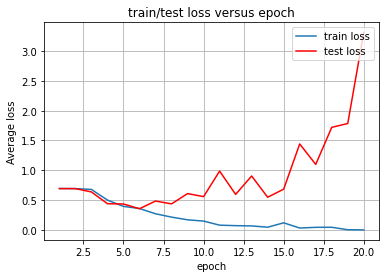

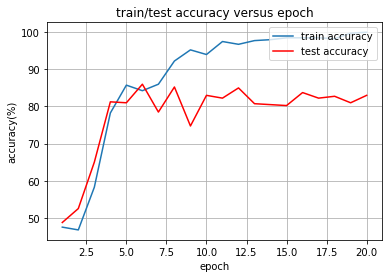

training and testing time(s) :  108.12610268592834


In [ ]:
################################################################################
# CNN w pretrained embedding             NETWORK, TRAINING, TESTING, PLOTTING  #
################################################################################

# NETWORK MAKING... #신버전 lr 0.001 실험중... # RNN w pretrained embedding

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import time
start_time = time.time()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = max_length
input_size = 100
num_of_kernels = 100
kernel_size = 3
stride = 2
num_layers = 1
num_classes = 1 # binary classification
#batch_size = 1 # dataloader에서 거기서 batch_size 값 넣어줘야됨.
num_epochs = 20
learning_rate = 0.001
vocab_size = len(word_to_ix) # 추가
embedding_dim = 100 # 추가

# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self, input_size, num_of_kernels, kernel_size, num_classes, stride, sequence_length):
        super(ConvNet, self).__init__()
        self.input_size = input_size
        self.num_of_kernels = num_of_kernels
        self.kernel_size = kernel_size
        
        self.num_classes = num_classes
        
        self.stride = stride
        self.sequence_length = sequence_length        
        
        self.conv1d_1 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_2 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_3 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_4 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_5 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_6 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_7 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        
        self.relu = nn.ReLU()

        self.fc = nn.Linear(1600, num_classes)
    
    def forward(self, x):
        
        
        # Set initial hidden and cell states 
        #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # 잠깐 h0, c0가 뭐지? shape은?
        
        # Forward propagate Conv1d
        
        # conv1d 는 lstm 과 달리 input을 (N,C_in,L) 로 인식함. (N:batch size, C_in:input vec dim,  L:seq length)
        # conv1d 에 input으로 x를 넣기 위해
        # x shape : (5,4096,100) -> (5,100,4096)으로 바꿔줘야함.
        x = torch.permute(x, (0,2,1))
        # x shape :torch.Size([5, 100, 4096]) 
        

        # seq 의 앞부분은 많은 수의 padding 때문에 feature가 제대로 저장되지 않았으므로, seq의 중간부터 뒷부분만 가져와서 conv에 태웠다.
        x = self.conv1d_1(x[:,:,2047:-1])  # x[:,:,2047:-1] shape : torch.Size([5, 100, 2048])
        # x shape : torch.Size([5, 100, 1024])
        x = self.relu(x)
        
        x = self.conv1d_2(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 512])
        x = self.relu(x)
        
        x = self.conv1d_3(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 256])
        x = self.relu(x)
       
        x = self.conv1d_4(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 128])
        x = self.relu(x)
    
        x = self.conv1d_5(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 64])
        x = self.relu(x)
        
        x = self.conv1d_6(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 32])
        x = self.relu(x)
        
        x = self.conv1d_7(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 16])
        x = self.relu(x)

        x = torch.flatten(x, start_dim=1, end_dim=-1)
        # x shape : torch.Size([5, 1600])
        
        # Decode the hidden state of the last time step
        x = self.fc(x)
        out = torch.sigmoid(x) #BCEWithLogitsLoss를 사용할땐, 여기선 sigmoid 사용안함.
        
        return out

model = ConvNet(input_size, num_of_kernels, kernel_size, num_classes, stride, sequence_length).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_dataloader)


train_loss  = []##
train_acc = []##
test_loss = []##
test_acc = []##
best_test_acc = -1##

for epoch in range(num_epochs):
    

    
    #test code##############
    #for i, (images, labels) in enumerate(train_dataloader):
    #    print("data:",images)
    #    print("labels:",labels)
    #    print()
    ########################
    
    

    ################# TRAIN ###############################
    tmp_train_loss = 0.0
    tmp_train_acc = 0.0
    train_corrects = 0
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            train_corrects = train_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_train_loss += loss.item()
        
    tmp_train_loss  /= len(train_dataloader)   
    tmp_train_acc = 100.0 * train_corrects/len(train_dataloader)
    train_loss.append(tmp_train_loss)
    train_acc.append(tmp_train_acc)
    
    print('epoch : {}, train acc : {} % , train loss : {}'.format(epoch+1, tmp_train_acc, tmp_train_loss))
    
    ################# TEST ###################################
    tmp_test_loss = 0.0
    tmp_test_acc = 0.0
    test_corrects = 0
    for i, (images, labels) in enumerate(test_dataloader):

        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            test_corrects = test_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_test_loss += loss.item()
        
    tmp_test_loss  /= len(test_dataloader)   
    tmp_test_acc = 100.0 * test_corrects/len(test_dataloader)
    test_loss.append(tmp_test_loss)
    test_acc.append(tmp_test_acc)
    
    print('epoch : {}, test acc : {} % , test loss : {}'.format(epoch+1, tmp_test_acc, tmp_test_loss))    
    
    #print("data:",out)###########################
    #print("shape:",out.shape)####################
    #print()#######################################
    
    
best_test_acc = max(test_acc)
print('best_test_acc : {} %'.format(best_test_acc))
    
    
x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test loss versus epoch")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.plot(x, train_loss, label="train loss")
plt.plot(x, test_loss, color='red', label="test loss")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test accuracy versus epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy(%)")
plt.plot(x, train_acc,label="train accuracy")
plt.plot(x, test_acc, color='red', label="test accuracy")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
################################################################################

print("training and testing time(s) : ",time.time() - start_time)

Epoch [1/30], Step [100/400], Loss: 0.7861
Epoch [1/30], Step [200/400], Loss: 0.6983
Epoch [1/30], Step [300/400], Loss: 0.6882
Epoch [1/30], Step [400/400], Loss: 0.6956
epoch : 1, train acc : 48.0 % , train loss : 0.6944021673126741
Epoch [1/30], Step [100/400], Loss: 0.7003
Epoch [1/30], Step [200/400], Loss: 0.6909
Epoch [1/30], Step [300/400], Loss: 0.6814
Epoch [1/30], Step [400/400], Loss: 0.6814
epoch : 1, test acc : 52.0 % , test loss : 0.6932174537069595
Epoch [2/30], Step [100/400], Loss: 0.6973
Epoch [2/30], Step [200/400], Loss: 0.6974
Epoch [2/30], Step [300/400], Loss: 0.6876
Epoch [2/30], Step [400/400], Loss: 0.6973
epoch : 2, train acc : 47.5 % , train loss : 0.693306544810337
Epoch [2/30], Step [100/400], Loss: 0.6918
Epoch [2/30], Step [200/400], Loss: 0.6918
Epoch [2/30], Step [300/400], Loss: 0.6972
Epoch [2/30], Step [400/400], Loss: 0.6918
epoch : 2, test acc : 50.0 % , test loss : 0.693168965602484
Epoch [3/30], Step [100/400], Loss: 0.6842
Epoch [3/30], Step 

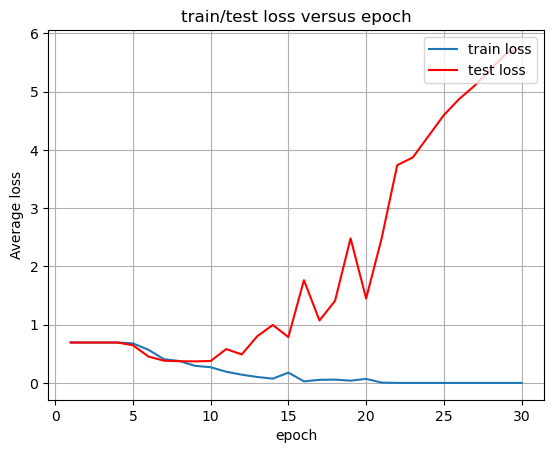

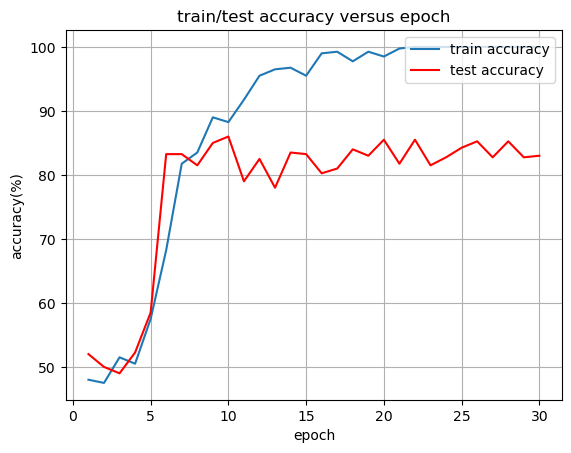

training and testing time(s) :  799.7599401473999


In [9]:
################################################################################
# CNN w pretrained embedding             NETWORK, TRAINING, TESTING, PLOTTING  #
################################################################################

# NETWORK MAKING... #신버전 lr 0.001 실험중... # RNN w pretrained embedding

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import time
start_time = time.time()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = max_length
input_size = 100
num_of_kernels = 100
kernel_size = 3
stride = 2
num_layers = 1
num_classes = 1 # binary classification
#batch_size = 1 # dataloader에서 거기서 batch_size 값 넣어줘야됨.
num_epochs = 30
learning_rate = 0.001
vocab_size = len(word_to_ix) # 추가
embedding_dim = 100 # 추가

# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self, input_size, num_of_kernels, kernel_size, num_classes, stride, sequence_length):
        super(ConvNet, self).__init__()
        self.input_size = input_size
        self.num_of_kernels = num_of_kernels
        self.kernel_size = kernel_size
        
        self.num_classes = num_classes
        
        self.stride = stride
        self.sequence_length = sequence_length        
        
        self.conv1d_1 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_2 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_3 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_4 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_5 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_6 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        self.conv1d_7 = nn.Conv1d(input_size, num_of_kernels, kernel_size, stride, padding=1)
        
        self.relu = nn.ReLU()

        self.fc = nn.Linear(1600, num_classes)
    
    def forward(self, x):
        
        
        # Set initial hidden and cell states 
        #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # 잠깐 h0, c0가 뭐지? shape은?
        
        # Forward propagate Conv1d
        
        # conv1d 는 lstm 과 달리 input을 (N,C_in,L) 로 인식함. (N:batch size, C_in:input vec dim,  L:seq length)
        # conv1d 에 input으로 x를 넣기 위해
        # x shape : (5,4096,100) -> (5,100,4096)으로 바꿔줘야함.
        x = torch.permute(x, (0,2,1))
        # x shape :torch.Size([5, 100, 4096]) 
        

        # seq 의 앞부분은 많은 수의 padding 때문에 feature가 제대로 저장되지 않았으므로, seq의 중간부터 뒷부분만 가져와서 conv에 태웠다.
        x = self.conv1d_1(x[:,:,2047:-1])  # x[:,:,2047:-1] shape : torch.Size([5, 100, 2048])
        # x shape : torch.Size([5, 100, 1024])
        x = self.relu(x)
        
        x = self.conv1d_2(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 512])
        x = self.relu(x)
        
        x = self.conv1d_3(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 256])
        x = self.relu(x)
       
        x = self.conv1d_4(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 128])
        x = self.relu(x)
    
        x = self.conv1d_5(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 64])
        x = self.relu(x)
        
        x = self.conv1d_6(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 32])
        x = self.relu(x)
        
        x = self.conv1d_7(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # x shape : torch.Size([5, 100, 16])
        x = self.relu(x)

        x = torch.flatten(x, start_dim=1, end_dim=-1)
        # x shape : torch.Size([5, 1600])
        
        # Decode the hidden state of the last time step
        x = self.fc(x)
        out = torch.sigmoid(x) #BCEWithLogitsLoss를 사용할땐, 여기선 sigmoid 사용안함.
        
        return out

model = ConvNet(input_size, num_of_kernels, kernel_size, num_classes, stride, sequence_length).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_dataloader)


train_loss  = []##
train_acc = []##
test_loss = []##
test_acc = []##
best_test_acc = -1##

for epoch in range(num_epochs):
    

    
    #test code##############
    #for i, (images, labels) in enumerate(train_dataloader):
    #    print("data:",images)
    #    print("labels:",labels)
    #    print()
    ########################
    
    

    ################# TRAIN ###############################
    tmp_train_loss = 0.0
    tmp_train_acc = 0.0
    train_corrects = 0
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            train_corrects = train_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_train_loss += loss.item()
        
    tmp_train_loss  /= len(train_dataloader)   
    tmp_train_acc = 100.0 * train_corrects/len(train_dataloader)
    train_loss.append(tmp_train_loss)
    train_acc.append(tmp_train_acc)
    
    print('epoch : {}, train acc : {} % , train loss : {}'.format(epoch+1, tmp_train_acc, tmp_train_loss))
    
    ################# TEST ###################################
    tmp_test_loss = 0.0
    tmp_test_acc = 0.0
    test_corrects = 0
    for i, (images, labels) in enumerate(test_dataloader):

        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        #print("data:",images)
        #print("labels:",labels)
        #print()
        
        #print("labels before as_tensor:",labels)
        #print("labels type before as_tensor:",type(labels))
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
        #print("labels after as_tensor:",labels)
        #print("labels type after as_tensor:",type(labels))
        
        # Forward pass
        outputs = model(images)

        #print("outputs before as_tensor:",outputs)##
        #print("outputs type before as_tensor:",type(outputs))##
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        #print("outputs after as_tensor:",outputs)##
        #print("outputs type after as_tensor:",type(outputs))
        
        if outputs[-1,0] > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels[-1]):
            test_corrects = test_corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1)) #labels.reshape(-1,1)를 하는 이유 : outputs는 shape=(batch_size,1)이고, labels 는 shape=(1,batch_size)이므로 labels의 shape을 (batch_size,1)로 바꿔야 함.
        # Backward and optimize
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_test_loss += loss.item()
        
    tmp_test_loss  /= len(test_dataloader)   
    tmp_test_acc = 100.0 * test_corrects/len(test_dataloader)
    test_loss.append(tmp_test_loss)
    test_acc.append(tmp_test_acc)
    
    print('epoch : {}, test acc : {} % , test loss : {}'.format(epoch+1, tmp_test_acc, tmp_test_loss))    
    
    #print("data:",out)###########################
    #print("shape:",out.shape)####################
    #print()#######################################
    
    
best_test_acc = max(test_acc)
print('best_test_acc : {} %'.format(best_test_acc))
    
    
x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test loss versus epoch")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.plot(x, train_loss, label="train loss")
plt.plot(x, test_loss, color='red', label="test loss")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test accuracy versus epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy(%)")
plt.plot(x, train_acc,label="train accuracy")
plt.plot(x, test_acc, color='red', label="test accuracy")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
################################################################################

print("training and testing time(s) : ",time.time() - start_time)

train acc : 50.65 % , train loss : 0.7040238108622648
train acc : 50.0 % , train loss : 0.6942278510030118
train acc : 50.0 % , train loss : 0.6943526396587708
train acc : 50.0 % , train loss : 0.694762694148885
train acc : 50.0 % , train loss : 0.6947128312110653
train acc : 50.0 % , train loss : 0.6949770822643789
train acc : 50.0 % , train loss : 0.6944679991521511
train acc : 50.0 % , train loss : 0.6938730317343604
train acc : 50.0 % , train loss : 0.6948154884929296
train acc : 50.0 % , train loss : 0.694560653120876
train acc : 50.0 % , train loss : 0.6945513055004807
train acc : 50.0 % , train loss : 0.6944405965053354
train acc : 50.0 % , train loss : 0.6940472796229079
train acc : 50.0 % , train loss : 0.6949527830952493
train acc : 50.0 % , train loss : 0.6949180452051904
train acc : 50.0 % , train loss : 0.6942236527996108
train acc : 50.0 % , train loss : 0.6953271689025888
train acc : 50.0 % , train loss : 0.6944122718997752
train acc : 50.0 % , train loss : 0.69417646522

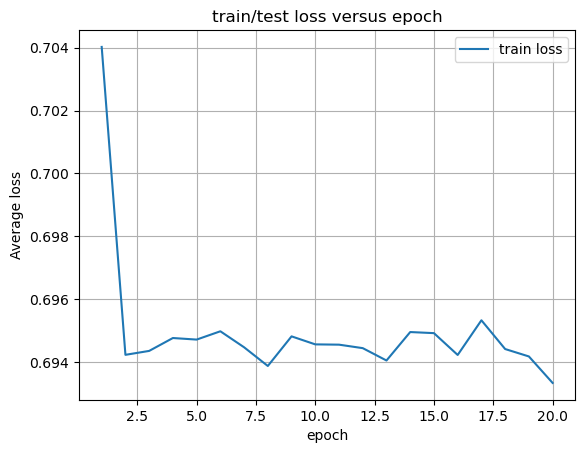

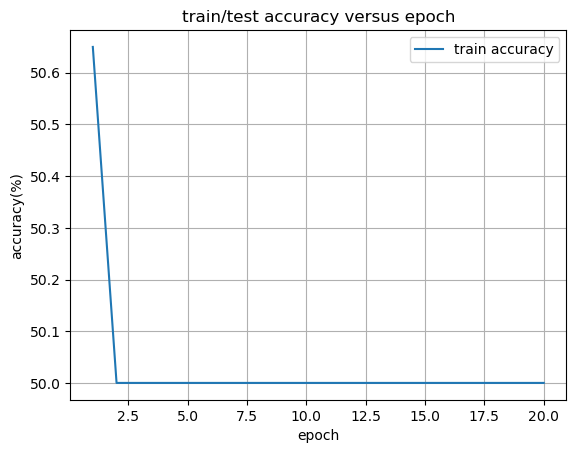

In [ ]:
################################################################################
#실험결과보관용 #학습이 전혀안된 경우, 예상원인:loss문제 or model output문제, 실제원인 : model output 문제(i.e. word embedding 시 post padding으로 인한 lstm output 의 backward timestep 들의 convergence 때문)
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = max_length
input_size = 100
hidden_size = 100
num_layers = 1
num_classes = 1 # binary classification
batch_size = 1 # 일단 1로
num_epochs = 20
learning_rate = 0.01
vocab_size = len(word_to_ix) # 추가
embedding_dim = 100 # 추가

# Recurrent neural network (many-to-one)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size # 추가
        self.embedding_dim = embedding_dim # 추가
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim) # 추가
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Embedding 추가
        x = self.embedding_layer(x) # 추가

        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        #out = torch.nn.functional.sigmoid(out) BCEWithLogitsLoss를 사용했기 때문에 여기선 sigmoid 사용안함.
        return out

model = LSTM(input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_dataloader)


train_loss  = []##
train_acc = []##
test_loss = []##
test_acc = []##
best_test_acc = -1##

for epoch in range(num_epochs):
    
    tmp_loss = 0.0
    tmp_acc = 0.0
    corrects = 0
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.reshape(-1, sequence_length).to(device)
        labels = labels.to(device)
        labels = torch.as_tensor(labels, dtype=torch.float64, device=device)

        # Forward pass
        outputs = model(images)
        outputs = torch.as_tensor(outputs, dtype=torch.float64, device=device)
        if outputs > 0.5:
            predict = 1
        else:
            predict = 0
        
        if predict == int(labels):
            corrects = corrects + 1
        else:
            pass
        
        loss = criterion(outputs, labels.reshape(-1,1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #if (i+1) % 100 == 0:
        #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        #           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        tmp_loss += loss.item()
        
    tmp_loss  /= len(train_dataloader)   
    tmp_acc = 100.0 * corrects/len(train_dataloader)
    train_loss.append(tmp_loss)
    train_acc.append(tmp_acc)
    
    print('train acc : {} % , train loss : {}'.format(tmp_acc, tmp_loss))
    
    
x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test loss versus epoch")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.plot(x, train_loss, label="train loss")
#plt.plot(x, test_loss, color='red', label="test loss")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

x = list(range(1, num_epochs+1))
plt.figure()
plt.title("train/test accuracy versus epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy(%)")
plt.plot(x, train_acc,label="train accuracy")
#plt.plot(x, test_acc, color='red', label="test accuracy")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
################################################################################

In [ ]:
################################################################################
# 이 아래는 각종 코드 기록용 셀들                                                    #
#                                                                              #
################################################################################

In [ ]:
# NETWORK # 구버전

import torch.nn as nn

class LSTMSentiClassifier(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim, num_layers = 1 ):
    super(LSTMSentiClassifier, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True) # 세번째 인자는 num_of_layers
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = self.embedding_layer(x)
    #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
    #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
    out, _ = self.lstm(x) # out: tensor of shape (batch_size, seq_length, hidden_size)
    out = self.fc(out[:, -1, :]) # lstm_out: shape=(N,L,H_out)임, lstm 의 각 seq(L) 중 가장 마지막 것만 가져올 것이므로, [:,-1,:] 로 index 를 줌.
    out = F.sigmoid(out)
    return out

#TRAINING TESTING # 구버전

EMBEDDING_DIM = 100
HIDDEN_DIM = 100
VOCAB_SIZE = len(word_to_ix)
OUTPUT_DIM = 1  # there are only 2 ground truths, positive(1) and negative(0)
NUM_LAYERS = 1

sequence_length = max_length

num_epochs = 5

model = LSTMSentiClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, OUTPUT_DIM, NUM_LAYERS).to(device)

criterion = nn.BCELoss() # loss function check!!!
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


checking_index = 115
# see what the scores are before training
#with torch.no_grad():
#  with open(join("drive/MyDrive/yonsei_hackathon/Yonsei-vnl-interview-assignment/Yonsei-visual_recog_lab-interview-assignment/data/train"+"/combined", str(checking_index)), 'r') as txt:
#    text = txt.readlines()
#  tokenized_sentence  = prepare_sequence(text[0], word_to_ix)
#  print("tokenized_sentence : ",tokenized_sentence)
#  print("tokenized_sentence.size(0) : ",tokenized_sentence.size(0))
#  print("tokenized_sentence.view(1,tokenized_sentence.size(0),-1) : ",1,-1,tokenized_sentence.view(tokenized_sentence.size(0)))
#  output = model(tokenized_sentence)
#  print(output)


# training iteration code
total_step =  len(train_dataloader)
for epoch in range(num_epochs):
  for i, (tokenized_sentences, labels) in enumerate(train_dataloader):

    tokenized_sentences = tokenized_sentences.to(device)
    labels = labels.to(device)
    labels = torch.as_tensor(labels, dtype=torch.float64, device=device)
    print(type(labels))

    output = model(tokenized_sentences)
    output = torch.as_tensor(output, dtype=torch.float64, device=device)
    print(type(output))

    loss = criterion(output, labels.reshape(-1,1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) %100 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
  
# testing iteration code
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for sentences, labels in test_dataloader:
    sentences = sentences.reshape(-1, sequence_length).to(device)
    labels = labels.to(device)
    output = model(sentences)
    predicted = 1 if output > 0.5 else 0
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Test Accuracy of the model in the 2000 test samples: {} %'.format(100 * correct / total))

# save the model checkpoint : 아직 코드 추가 안함. 링크 : https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/recurrent_neural_network/main.py


# see what the scores are after training
with torch.no_grad():
  with open(join("drive/MyDrive/yonsei_hackathon/Yonsei-vnl-interview-assignment/Yonsei-visual_recog_lab-interview-assignment/data/train"+"/combined", str(checking_index)), 'r') as txt:
    text = txt.readlines()
  tokenized_sentence = prepare_sequence(text[0], word_to_ix)
  tokenized_sentence = tokenized_sentence.reshape(-1, sequence_length).to(device)
  output = model(tokenized_sentence)
  print(output)

In [ ]:
########################################################
# torch.permute 자주 쓰자! 유용하다!                       #
########################################################
x = torch.randn(2, 3, 5)
x.size()
torch.permute(x, (2, 0, 1)).size()

torch.Size([5, 2, 3])

In [ ]:
# word to index 는 한번에 한 문장씩만 가능한듯
def f(seq, to_ix):
  idxs = [to_ix[w] if w in to_ix else to_ix['<unk>'] for w in seq] #  else '<unk>'
  return torch.tensor(idxs, dtype=torch.long)

wd_to_ix = {}
wd_to_ix['<unk>'] = 0
wd_to_ix['<pad>'] = 1
list_tmp = [('a',100),('b',100),('c',100),('d',100),('e',100)]
for wd in list_tmp:
  if wd[0] not in wd_to_ix:
    wd_to_ix[wd[0]] = int(len(wd_to_ix))

x = ['a','b','v','d']
#x = [['a','b','v','d'],['a','b','c','d']]
print(f(x,wd_to_ix))

tensor([2, 3, 0, 5])


In [ ]:
ordered_dic = OrderedDict()
ordered_dic[103] = 1
ordered_dic[100] = 1
ordered_dic[102] = 0
ordered_dic[101] = 10
print("----------------------")
print(ordered_dic)
print(ordered_dic[101])
ordered_dic = OrderedDict(sorted(ordered_dic.items(), key=lambda item: item))
print(ordered_dic)
print(ordered_dic[101])

----------------------
OrderedDict([(103, 1), (100, 1), (102, 0), (101, 10)])
10
OrderedDict([(100, 1), (101, 10), (102, 0), (103, 1)])
10


In [ ]:
idxs = [10, 30, 50, 70]
while(len(idxs) < 10):
  idxs.append(1) #padding
print(torch.tensor(idxs, dtype=torch.long))

tensor([10, 30, 50, 70,  1,  1,  1,  1,  1,  1])


In [ ]:
print(join("drive/MyDrive/yonsei_hackathon/Yonsei-vnl-interview-assignment/Yonsei-visual_recog_lab-interview-assignment/data/train"+"/negative",str(3)))
print()
print(join("drive/MyDrive/yonsei_hackathon/Yonsei-vnl-interview-assignment/Yonsei-visual_recog_lab-interview-assignment/data/train"+"/negative","apple"))
print()
print(join("drive/MyDrive/yonsei_hackathon/Yonsei-vnl-interview-assignment/Yonsei-visual_recog_lab-interview-assignment/data/train"+"/negative","/apple"))

drive/MyDrive/yonsei_hackathon/Yonsei-vnl-interview-assignment/Yonsei-visual_recog_lab-interview-assignment/data/train/negative/3

drive/MyDrive/yonsei_hackathon/Yonsei-vnl-interview-assignment/Yonsei-visual_recog_lab-interview-assignment/data/train/negative/apple

/apple


In [ ]:
list_ = ["a" if i < 3 else "b" for i in [1,2,3,4]  ]
print( list_)

['a', 'a', 'b', 'b']


In [ ]:
x = torch.tensor([[1,2,3,4,5,6,7,8],[9,10,11,12,13,14,15,16]])
y = x.view(4,4)
print(y)

In [ ]:
tokenized_sentence  = prepare_sequence("I am a boy .", word_to_ix)
print(len(tokenized_sentence))
print(tokenized_sentence)

In [ ]:
embedding_layer = nn.Embedding(len(word_to_ix), 4)
embeddings = embedding_layer(torch.tensor([[1,2,3],[4,5,6]]))
print(embeddings)

In [ ]:
x = torch.tensor([[1,2,3],[4,5,6]])
print(x.shape)
print(x.shape[0])
print(x.shape[1])

torch.Size([2, 3])
2
3


In [ ]:
tple = [('the',0),('a',1)]
print(tple[0][0])

the


In [ ]:
############################################################################
# einsum 공부 좀 하자                                                        #
############################################################################
A = torch.tensor([[[1,2,3],[4,5,6]],[[7,8,9],[10,11,12]]])
print(A)
B = np.einsum("ijk->jik", A)
B = torch.tensor(B)
print(B)
#print(B)

tensor([[[ 1,  2,  3],
         [ 4,  5,  6]],

        [[ 7,  8,  9],
         [10, 11, 12]]])
tensor([[[ 1,  2,  3],
         [ 7,  8,  9]],

        [[ 4,  5,  6],
         [10, 11, 12]]])
